In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from pathlib import Path
from typing import Tuple
from PIL import Image
import pandas as pd
import boto3
from botocore.client import Config
import random

In [ ]:
project_root    = Path().resolve().parent   # adjust if needed
datasets_path   = project_root / "data" / "raw_data"
dataset1_path   = Path(datasets_path) / "dataset1"
dataset2_path   = Path(datasets_path) / "dataset2"
dataset3_path   = Path(datasets_path) / "dataset3"
dataset4_path   = Path(datasets_path) / "dataset4"
dataset5_path   = Path(datasets_path) / "dataset5" / "additional_images"

medium_ds_root    = project_root / "merged_dataset"
datasets_path     = project_root / "datasets"
dataset1_path     = datasets_path / "dataset1"
dataset2_path     = datasets_path / "dataset2"
dataset3_path     = datasets_path / "dataset3"
dataset4_path     = datasets_path / "dataset4"
dataset5_path     = project_root / "data_extraction" / "additional_images"

splits           = ['train', 'dev', 'test']
split_ratios     = {'train': 0.8, 'dev': 0.1, 'test': 0.1}

In [2]:
# Countries of interest
COUNTRIES = ['Albania', 'Andorra', 'Australia', 'Austria', 'Bangladesh', 'Belgium', 'Bhutan', 'Bolivia', 'Brazil', 'Bulgaria', 'Cambodia', 'Canada', 'Chile', 'Colombia', 'Croatia', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Estonia', 'Eswatini', 'Finland', 'France', 'Germany', 'Greece', 'Guatemala', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan', 'Jordan', 'Latvia', 'Lesotho', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mexico', 'Montenegro', 'Netherlands', 'New Zealand', 'North Macedonia', 'Norway', 'Palestine', 'Peru', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'United Arab Emirates', 'United Kingdom', 'United States']
len(COUNTRIES)

66

# Merge datasets

## Analyze distribution

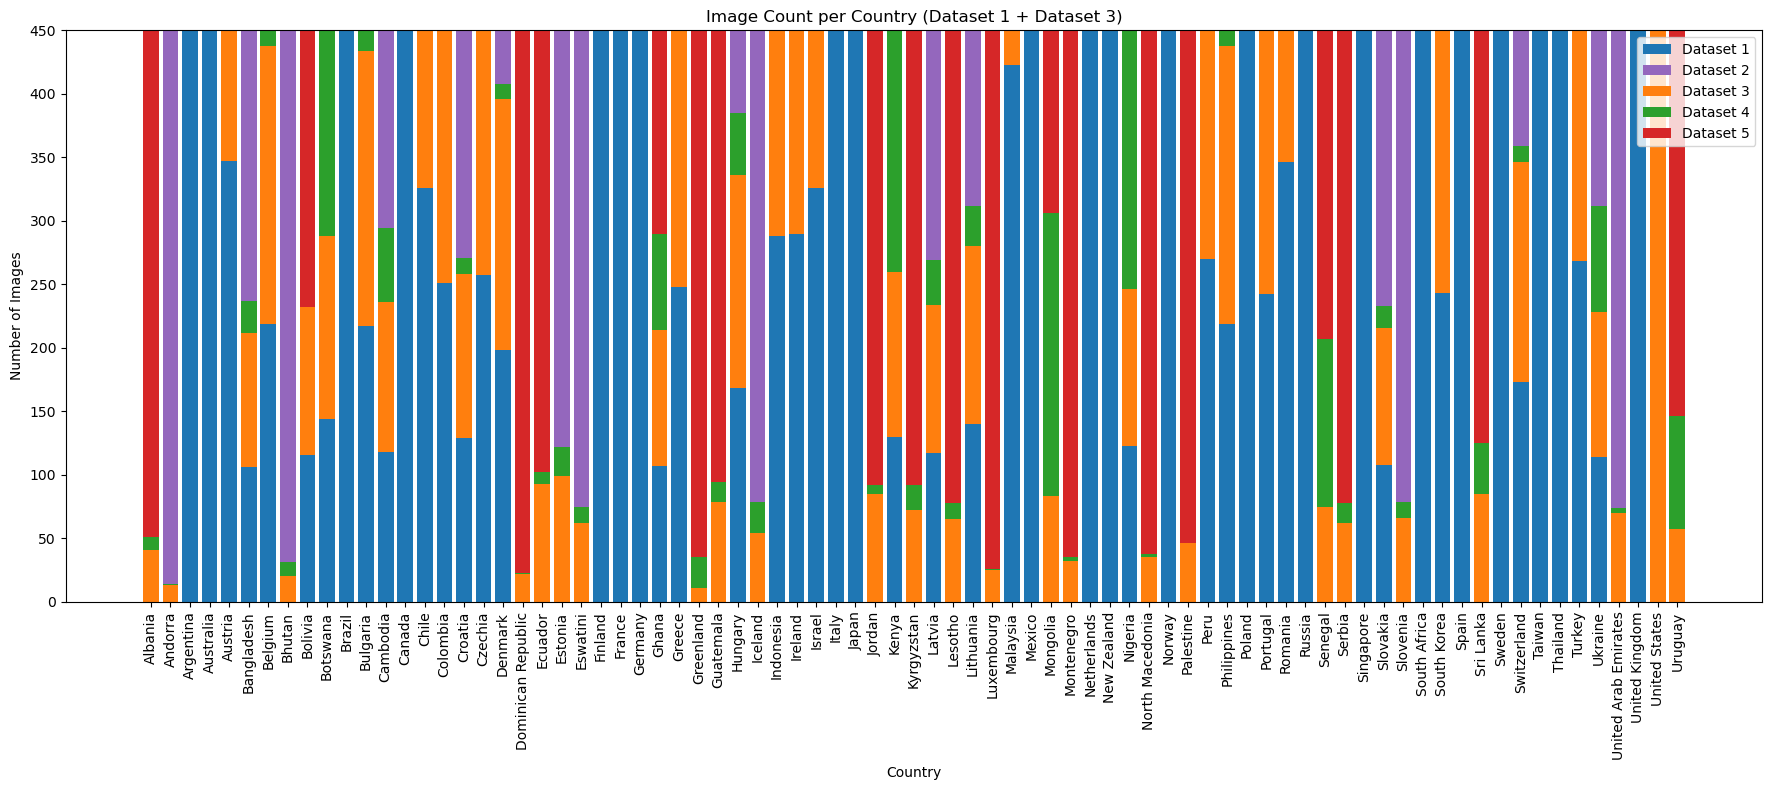

In [ ]:
# Plot
labels = COUNTRIES
ds1_vals = np.array([counts1.get(c, 0) for c in labels])
ds2_vals = np.array([counts2.get(c, 0) for c in labels]) * 3
ds3_vals = np.array([counts3.get(c, 0) for c in labels])
ds4_vals = np.array([counts4.get(c, 0) for c in labels])
ds5_vals = np.array([counts5.get(c, 0) for c in labels])

x = np.arange(len(labels))

plt.figure(figsize=(18, 8))
plt.bar(x, ds1_vals, label='Dataset 1', color='#1f77b4')
plt.bar(x, ds2_vals, bottom=ds1_vals + ds3_vals + ds4_vals + ds5_vals, label='Dataset 2', color='#9467bd')
plt.bar(x, ds3_vals, bottom=ds1_vals, label='Dataset 3', color='#ff7f0e')
plt.bar(x, ds4_vals, bottom=ds1_vals + ds3_vals, label='Dataset 4', color='#2ca02c')
plt.bar(x, ds5_vals, bottom=ds1_vals + ds3_vals + ds4_vals, label='Dataset 5', color='#d62728')

plt.xticks(x, labels, rotation=90)
plt.xlabel('Country')
plt.ylabel('Number of Images')
plt.title('Image Count per Country')
plt.legend()
plt.tight_layout()
plt.ylim(0, 450)
plt.show()

## Analyse image sizes

In [ ]:
# 1) Define where your datasets live 
dataset_paths = {
    "Dataset1": datasets_path / "dataset1",
    "Dataset2": datasets_path / "dataset2",
    "Dataset3": datasets_path / "dataset3",
    "Dataset4": datasets_path / "dataset4",
    "Dataset5": project_root / "data_extraction" / "additional_images"
}

# 2) For each dataset, grab the first image found and record its size
records = []
for name, root in dataset_paths.items():
    sample_name, w, h = None, None, None
    if root.exists():
        for path in root.rglob("*"):
            if path.suffix.lower() in (".jpg", ".jpeg", ".png"):
                try:
                    with Image.open(path) as img:
                        w, h = img.size
                    sample_name = path.name
                    break
                except:
                    continue
    records.append({
        "Dataset":     name,
        "Sample File": sample_name,
        "Width":       w,
        "Height":      h
    })

# 3) Build a DataFrame and show it
df = pd.DataFrame(records)

In [140]:
df

,Dataset,Sample File,Width,Height
0,Dataset1,test_03041.jpg,1536,662
1,Dataset2,BT_03530.jpg,3030,561
2,Dataset3,canvas_1629262074.jpg,1536,662
3,Dataset4,9848.png,640,640
4,Dataset5,Luxembourg_417.jpg,640,640


## Create merged dataset

In [ ]:
def center_crop_to_square(img: Image.Image, target_size) -> Image.Image:
    """Crop the largest possible centered square from img."""
    w, h = img.size
    side = min(w, h)
    left = (w - side) // 2
    top  = (h - side) // 2
    crop = img.crop((left, top, left + side, top + side))
    # 2) resize to fixed square
    return crop.resize((target_size, target_size), Image.BILINEAR)

In [38]:
def split_by_three(image_path: str) -> Tuple[Image.Image, Image.Image, Image.Image]:
    """
    Splits an image into three equal vertical chunks.

    Parameters:
    - image_path (str): Path to the input image.

    Returns:
    - Tuple[Image.Image, Image.Image, Image.Image]: Three PIL Image objects representing the chunks.
    """
    image = Image.open(image_path)
    width, height = image.size
    chunk_width = width // 3

    chunk1 = image.crop((0, 0, chunk_width, height))
    chunk2 = image.crop((chunk_width, 0, 2 * chunk_width, height))
    chunk3 = image.crop((2 * chunk_width, 0, width, height))

    return chunk1, chunk2, chunk3

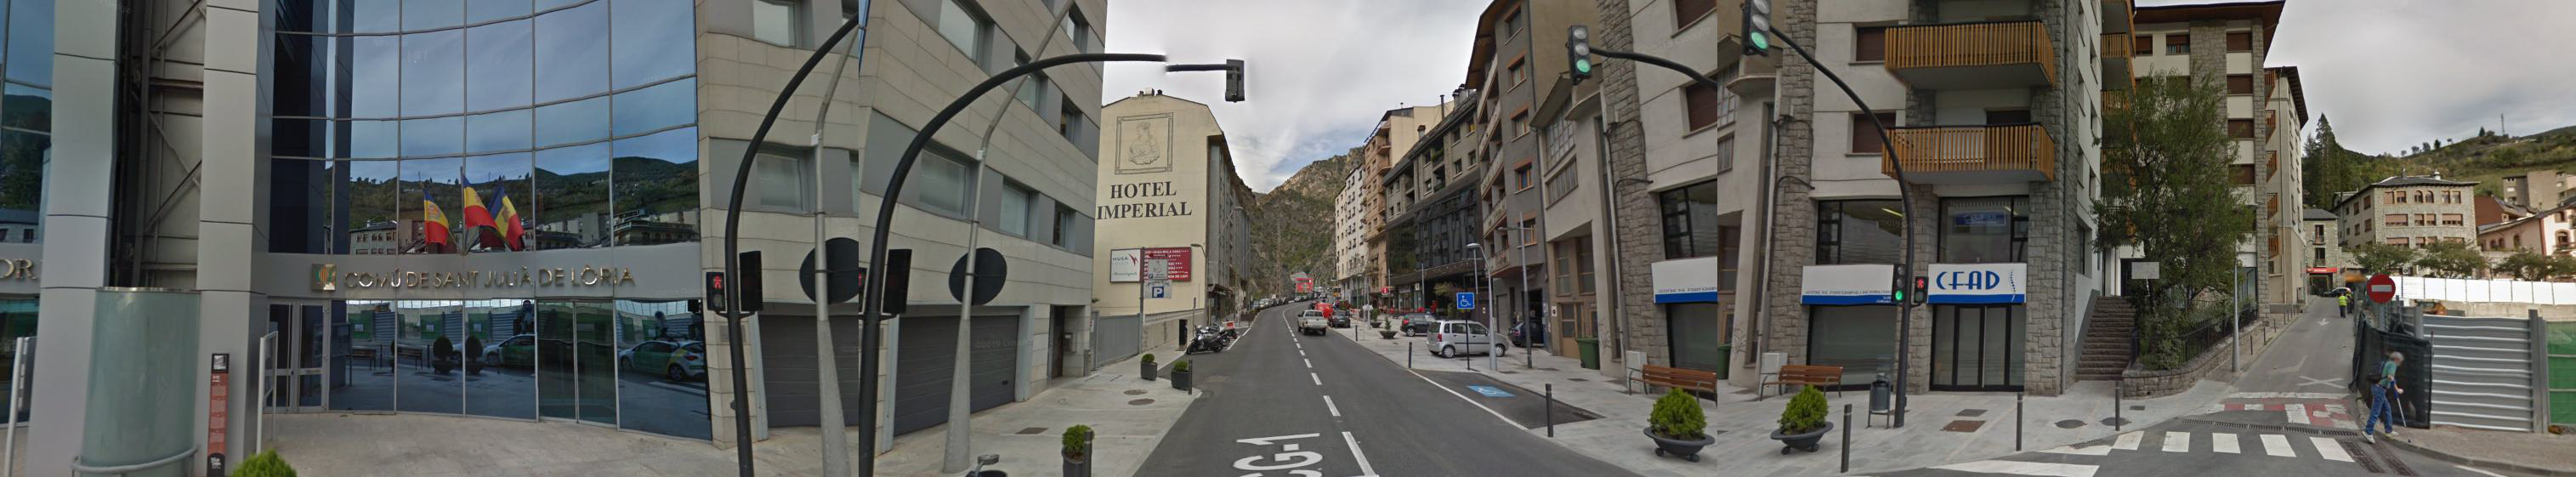

In [180]:
# show one random image in dataset 2
dataset2_path = dataset_paths["Dataset2"]
sample_path = dataset2_path / "Andorra" / "AD_00364.jpg"
sample_path.exists()
sample = Image.open(sample_path)
sample

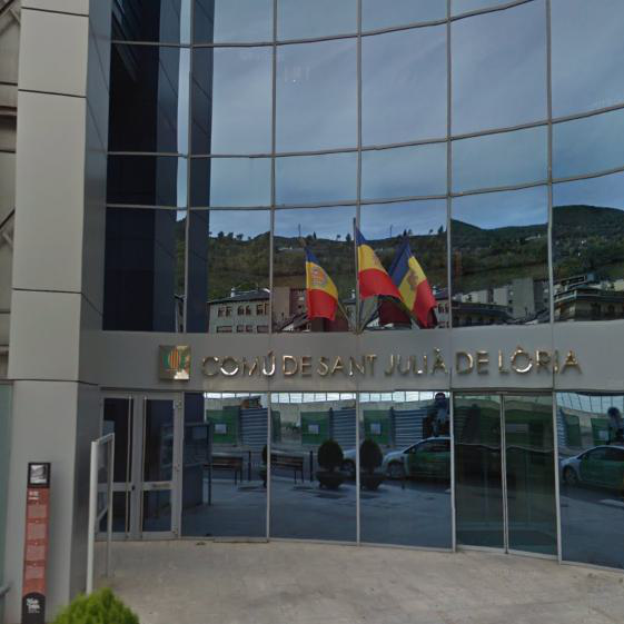

In [182]:
chunk1, chunk2, chunk3 = split_by_three(sample_path)
center_crop_to_square(chunk1, 624)

In [46]:
def gather_images_for_country(country: str, TARGET_COUNT):
    out = []
    def list_imgs(ds_path):
        folder = ds_path / country
        if not folder.is_dir(): return []
        return [p for p in folder.rglob("*")
                if p.suffix.lower() in (".jpg", ".jpeg", ".png")]

    # Change priority: (path, crop, from_ds2)
    sources = [
        (dataset1_path, True,  False),
        (dataset3_path, True,  False),
        (dataset5_path, False, False),
        (dataset2_path, True,  True),   # mark ds2
        (dataset4_path, False, False),
    ]

    print(f"\nCountry '{country}':")
    for i,(ds,_,f2) in enumerate(sources,1):
        print(f" Source{i}: {ds.name} = {len(list_imgs(ds))} imgs")

    # build list
    for ds_path, crop_flag, from_ds2 in sources:
        for p in list_imgs(ds_path):
            out.append((p, crop_flag, from_ds2))

    # dedupe + trim
    seen, final = set(), []
    for src, crop_flag, from_ds2 in out:
        if src in seen: continue
        seen.add(src)
        final.append((src, crop_flag, from_ds2))
        if len(final) >= TARGET_COUNT:
            break

    print(f" -> selected: {len(final)}")
    return final


In [52]:
for split in splits:
    for country in COUNTRIES:
        (medium_ds_root / split / country).mkdir(parents=True, exist_ok=True)

In [ ]:
# ─── MAIN LOOP  ─────────────────────────────────
# Ensure top‐level split folders exist
for split in ("train", "dev", "test"):
    (medium_ds_root / split).mkdir(exist_ok=True)

# Process each country in turn, streaming picks into train/dev/test
for country in COUNTRIES:
    picks = gather_images_for_country(country, TARGET_COUNT=450)
    print(f"\nCountry '{country}': picked {len(picks)} sources")

    # Set up quotas
    quotas = {"train": 360, "dev": 45, "test": 45}

    pick_idx = 0
    # For each split, write exactly quota images into split/country
    for split, quota in quotas.items():
        out_dir = medium_ds_root / split / country
        out_dir.mkdir(parents=True, exist_ok=True)

        saved = 0
        while saved < quota and pick_idx < len(picks):
            src_path, do_crop, from_ds2 = picks[pick_idx]

            if from_ds2:
                for chunk in split_by_three(src_path):
                    if saved >= quota:
                        break
                    img = center_crop_to_square(chunk, 624)
                    fname = f"{saved+1:03d}.jpg"
                    img.save(out_dir / fname)
                    saved += 1
            else:
                img = Image.open(src_path).convert("RGB")
                if do_crop:
                    img = center_crop_to_square(img, 624)
                fname = f"{saved+1:03d}.jpg"
                img.save(out_dir / fname)
                saved += 1

            # advance to next pick only after emitting all chunks
            pick_idx += 1

        print(f"  {split}/{country}: saved {saved} images")

print("All done.")



Country 'Albania':
 Source1: dataset1 = 0 imgs
 Source2: dataset3 = 41 imgs
 Source3: additional_images = 503 imgs
 Source4: dataset2 = 0 imgs
 Source5: dataset4 = 10 imgs
 -> selected: 450

Country 'Albania': picked 450 sources
  train/Albania: saved 360 images
  dev/Albania: saved 45 images
  test/Albania: saved 45 images

Country 'Andorra':
 Source1: dataset1 = 0 imgs
 Source2: dataset3 = 13 imgs
 Source3: additional_images = 0 imgs
 Source4: dataset2 = 205 imgs
 Source5: dataset4 = 1 imgs
 -> selected: 219

Country 'Andorra': picked 219 sources
  train/Andorra: saved 360 images
  dev/Andorra: saved 45 images
  test/Andorra: saved 45 images

Country 'Argentina':
 Source1: dataset1 = 689 imgs
 Source2: dataset3 = 689 imgs
 Source3: additional_images = 0 imgs
 Source4: dataset2 = 210 imgs
 Source5: dataset4 = 905 imgs
 -> selected: 450

Country 'Argentina': picked 450 sources
  train/Argentina: saved 360 images
  dev/Argentina: saved 45 images
  test/Argentina: saved 45 images

Count